In [15]:
import tensorflow as tf
import numpy as np
import cv2
import os
import random

import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.models import load_model

In [16]:
base_dir = './images/overlap/'

images_dir = base_dir + 'tiles'
masks_dir =  base_dir + 'masks'

images_listdir = [img for img in os.listdir(images_dir) if img.endswith('jpg')]
masks_listdir = [img for img in os.listdir(masks_dir) if img.endswith('jpg')]

IMG_SIZE = 512

MASKS = np.zeros((1, IMG_SIZE, IMG_SIZE, 1), dtype=bool)
IMAGES = np.zeros((1, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


for img_file, mask_file in zip(images_listdir, masks_listdir):
    fpath = f'images/overlap/tiles/{img_file}'
    image = read_image(fpath)
    image_ex = np.expand_dims(image, axis=0)
    IMAGES = np.vstack([IMAGES, image_ex])

    fpath = f'images/overlap/masks/{mask_file}'
    mask = read_image(fpath)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = mask.reshape(IMG_SIZE, IMG_SIZE, 1)
    mask_ex = np.expand_dims(mask, axis=0)
    MASKS = np.vstack([MASKS, mask_ex])

images=np.array(IMAGES)
masks=np.array(MASKS)

TRAIN_RATIO = 0.70
VALIDATION_RATIO = 0.2
TEST_RATIO = 0.1

X_train, X_temp, y_train, y_temp = train_test_split(
    images, masks, test_size=(1-TRAIN_RATIO), random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(TEST_RATIO/(TEST_RATIO + VALIDATION_RATIO)), random_state=42)

In [17]:
unet_model = load_model('./modelos/unet_512_20epochs_gpu_v2.keras')

In [18]:
masks_pred = unet_model.predict(X_test, batch_size=1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step


In [25]:
masks_pred[0]

array([[[1.       ],
        [1.       ],
        [1.       ],
        ...,
        [1.       ],
        [1.       ],
        [1.       ]],

       [[1.       ],
        [0.9989141],
        [0.9999995],
        ...,
        [1.       ],
        [1.       ],
        [1.       ]],

       [[1.       ],
        [0.9992225],
        [1.       ],
        ...,
        [1.       ],
        [1.       ],
        [1.       ]],

       ...,

       [[1.       ],
        [1.       ],
        [1.       ],
        ...,
        [1.       ],
        [1.       ],
        [1.       ]],

       [[1.       ],
        [1.       ],
        [1.       ],
        ...,
        [1.       ],
        [1.       ],
        [1.       ]],

       [[1.       ],
        [1.       ],
        [1.       ],
        ...,
        [1.       ],
        [1.       ],
        [1.       ]]], dtype=float32)

In [20]:
def show_image(image, cmap=None, title=None):
  plt.imshow(image, cmap=cmap)
  if title is not None: plt.title(title)
  plt.axis('off')

In [21]:
def mask_threshold(image, threshold=0.25):
  return image>threshold

def plot_results(image, mask, prediction, n, threshold=0.4):
    # k = np.random.randint(len(images_test))
    # original_image = images_test[k]
    # mask = mask_test[k].reshape(128, 128)
    # predicted_mask = predictions[k].reshape(128, 128)
    threshold_mask = mask_threshold(prediction, threshold=threshold)

    plt.figure(figsize=(15,5))

    plt.subplot(1,4,1)
    plt.imshow(image);plt.title('Orginal Image')

    plt.subplot(1,4,2)
    plt.imshow(mask, cmap='gray');plt.title('Original Mask')

    plt.subplot(1,4,3)
    plt.imshow(prediction, cmap='gray');plt.title(f'Predicted Mask {n}')

    plt.subplot(1,4,4)
    plt.imshow(threshold_mask, cmap='gray');plt.title(f'Predicted Mask with cutoff={threshold}')

    plt.tight_layout()
    plt.show()

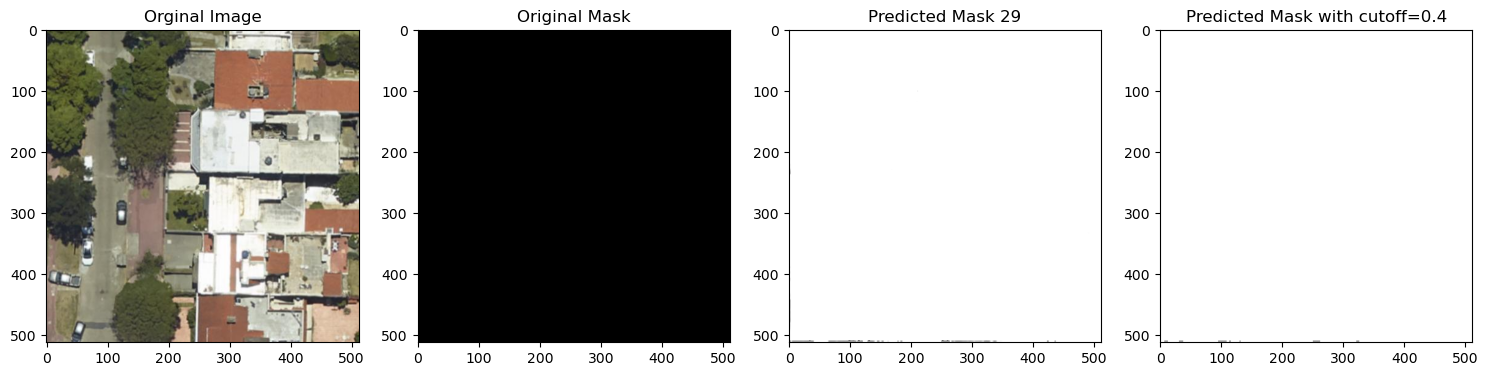

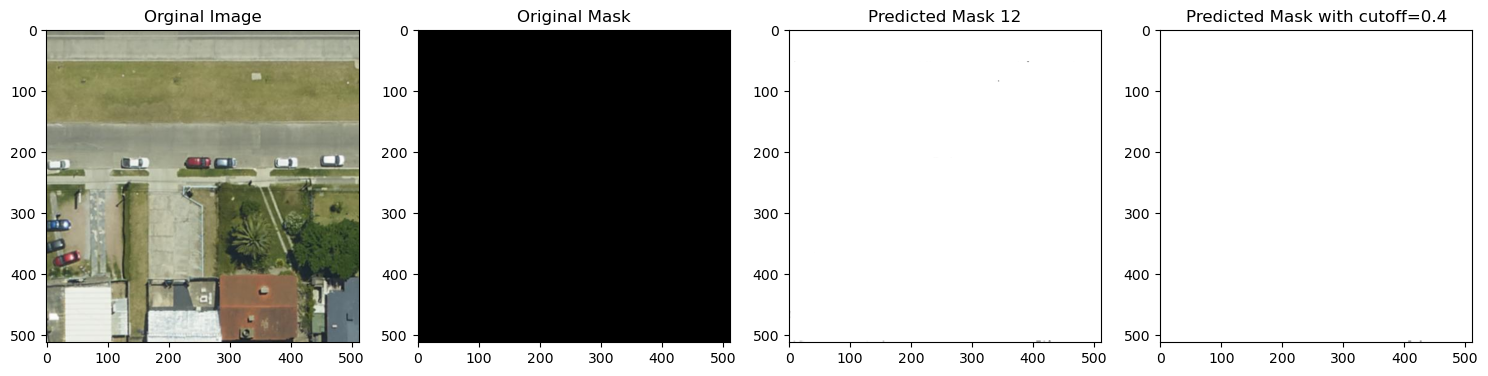

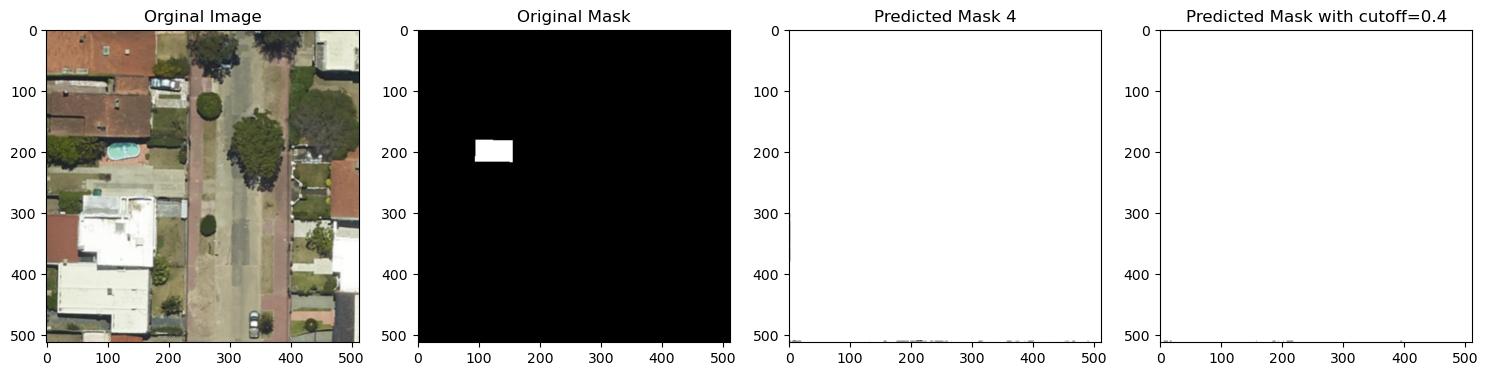

In [26]:
for i in random.sample(range(len(X_test)), 3):
    plot_results(X_test[i], y_test[i], masks_pred[i]*255, i)

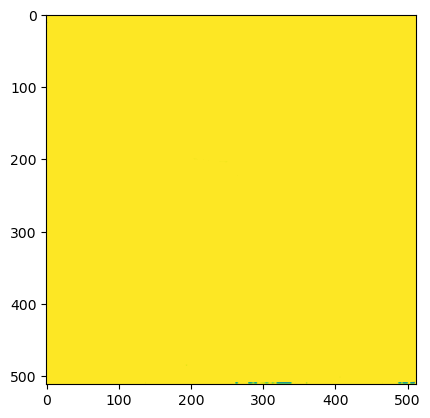

In [27]:
plt.imshow(masks_pred[35])

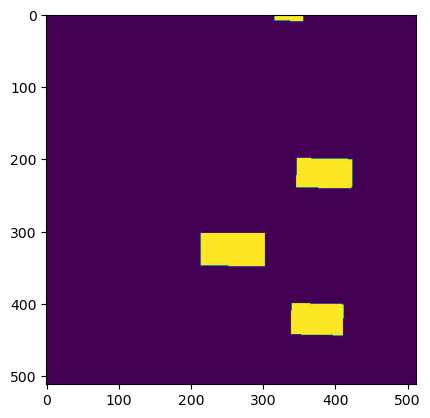

In [28]:
plt.imshow(y_test[35])

In [30]:
np.max(y_test[35])

255